In [1]:
! pip install graphviz
! pip install pydot
! pip install WordCloud

In [2]:
import numpy as np
from scipy.special import gammaln
import random
from collections import Counter
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import graphviz
import pydot
import pygraphviz

### 1. Read in data set

We read in the **pubmed.pic.** data that we used in the previous homework as an example. We also generated a very simple example by several letters

In [3]:
docs=pickle.load(open('pubmed.pic', 'rb'))
docslist=[]
docs_list=list(docs)
for j in range(10):
    corpus=[]
    for i in range(10):
        corpus=corpus+[docs_list[i+j*10]]
    docslist.append(str(corpus))
corpus=[x.split(" ")  for x in docslist]

corpus1=corpus

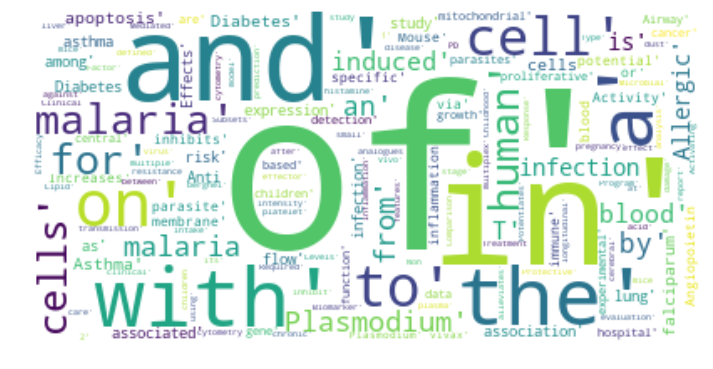

In [4]:
wordcloud = WordCloud(background_color='white').generate(str(corpus1))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

a simple example made by ourselve

In [5]:
corpus2=[['a'],['b','c','d'],['e','f','a','c'],['g','d','e','b','a']]

a make up topic

In [6]:
topic=[['a', 'ggtfdg', 'dsgfgfd', 'ds', 'ds', 'yhhr'], ['123', '66']]

### 2. Code process
2.1 **CRP_next**: Calculate the probability for a new customer set in the $n$th table 

In [7]:
def CRP_next(lambdas,topic):
    """
    Description
    ---------
    Funcion: Chinese Restaurant Process
    
    Parameter
    ---------
    alpha: concentration parameter 
    topic: the exist tables 
    
    Return
    ------
    p: the probability for a new customer to sit in each of the tables
    """
    import numpy as np
    N=len(topic) # number of tables
    word_list=[] # total customers
    for t in topic:
        word_list=word_list+t
    m=len(word_list) # customers' number
    
    tables = np.array([len(x) for x in topic])  # tables with their customers
    p_old=tables/(lambdas+m) # the probability of sitting in a table with other people   
    p_new=lambdas/(lambdas+m)      # the probability of sitting in a new table
    p=[p_new]+list(p_old)  # the last probability is the probability to sit in a new table 
    return(p)

 Example
 + the first number is probability to the set in a new table
 + the following number is the probability to sit in old tables

In [8]:
CRP_next(1,topic) 

[0.1111111111111111, 0.6666666666666666, 0.2222222222222222]

2.2 **topics**: get the topic number of the corpus

In [10]:
def topics(corpus,lambdas):
    """
    Description
    ---------
    Funcion: get a topic list based on CRP
    
    Parameter
    ---------
    lambda: concentration parameter 
    corpus: a list of lists 
    
    Return
    ------
    topic: a list of lists
    """
    topic=[]
    for docs in corpus:
        for word in docs:
            p=CRP_next(lambdas,topic)
            position=np.random.multinomial(1, list((np.array(p)/sum(p))))
            position=int(np.where(position!=0)[0])
            if position==0:
                topic.append([word])
            else:
                topic[position-1].append(word)
    return(topic)

Example

In [11]:
lambdas=4
len(topics(corpus1,lambdas))

19

In [12]:
np.random.seed(2)
topics(corpus2,lambdas)

[['a'], ['b'], ['c', 'c', 'a'], ['d', 'e', 'a', 'g', 'd', 'e', 'b'], ['f']]

2.3 **Z** 

The $z_{m,n}$ is sampled under LDA model based on the method in paper:

\begin{align*}
p(z_{i}=j\hspace{0.5ex}|\hspace{0.5ex}{\bf z}_{-i},{\bf w})\propto\frac{n_{-i,  j}^{(w_{i})}+\beta}{n_{-i, j}^{(\cdot)}+W\beta}\frac{n^{(d_{i})}+\alpha}{n_{-i,\cdot}^{(d_{i})}+T\alpha}
\end{align*}

where:

 + $z_{i}$ is the assignments of words to topics;
 + $n_{-i,j}^{(w_{i})}$ is number of words assigned to topic $j$ that are the same as $w_i$; 
 + $n_{-i,j}^{(\cdot)}$ is total number of words assigned to topic $j$; 
 + $n_{-i,j}^{(d_{i})}$ shows number of words from document $d_i$ assigned to topic $j$, $n_{-i,\cdot}^{(d_{i})}$ represents total number of words in document $d_i$;
 + $W$ shows number of words have been assigned
 + $\alpha,\beta$: free parameters that determine how heavily these empirical distributins are smoothed.

In [14]:
def Z(corpus, T, alpha, beta):
    """
    Description
    ---------
    Funcion:  sample zmn under LDA model
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    T: the number of topics
    alpha, beta: parameters
    
    Return
    ------
    topic: the word list in each topic
    topic_num: the length of each topic
    """
    import numpy as np
    W=np.sum([len(word) for word in corpus]) # the number of the total words
    N=len(corpus)                            # the number of documents 
    topic=[[] for t in range(T)]
    topic_num=[[] for t in range(T)]
    for i,di in enumerate(corpus):
        for wi in di:
            p=np.zeros(T)
            for j in range(T):
                nij_wi=topic[j].count(wi)   # number of wi tht assigned to topic j
                nij=len(topic[j])           # total number of words assigned to topic j 
                nij_di=np.sum(np.isin(topic[j],di)) # number of words from di in topic j
                ni_di=len(di)               # total number of words in di
                part1=(nij_wi+beta)/(nij+W*beta)
                part2=(nij_di+alpha)/(ni_di+T*alpha)
                p[j]=part1 * part2
            pp=p/np.sum(p)
            w_assign=np.random.multinomial(1, pp, size=1)
            i_topic=int(np.where(w_assign[0]==1)[0])
            topic[i_topic].append(wi)
            topic_num[i_topic].append(i)
    return(topic,topic_num)

Example

In [15]:
T=4
alpha=1
beta=1
topic11, topic12=Z(corpus1, T, alpha, beta)

In [16]:
np.random.seed(2)
T=2
alpha=1
beta=1
topic21, topic22=Z(corpus2, T, alpha, beta)
print(topic21)
print(topic22)

[['b', 'c', 'd', 'c', 'd', 'b'], ['a', 'e', 'f', 'a', 'g', 'e', 'a']]
[[1, 1, 1, 2, 3, 3], [0, 2, 2, 2, 3, 3, 3]]


2.4 **word_likelihood$**: 

The calculation of the $p(w_m | c, w_{-m},z)$ value based on the likelihood function: 

$$p(w_m | c, w_{-m},z) = \prod_{l=1}^{L} (\frac{\Gamma (n_{c_{m,l,-m}}^{(\cdot)}+W\eta)}{\prod_{\omega} \Gamma (n_{c_{m,l,-m}}^{(\omega)}+\eta)}\frac{\prod_{\omega} \Gamma(n_{c_{m,l,-m}}^{(\omega)}+n_{c_{m,l,m}}^{(\cdot)}+\eta)}{\Gamma(n_{c_{m,l,-m}}^{(\cdot)}+ n_{c_{m,l,m}}^{(\cdot)}  W\eta)})$$

where, 

 + $n^{(w)}_{c_m,I,-m}$: the number of word $w$ that have been assigned to the topic indexed y $c_{m,l}$ not including those in the current document
 + $W$: the total vocabulary size
 + $\eta$: free parameter

In [18]:
def word_likelihood(corpus,topic,eta):
    """
    Description
    ---------
    Funcion:  the p(w_m | c, w_{-m},z) likelihood function
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    topic: the exist topics
    eta: free parameters
    
    Return
    ------
    res: a matrix with rownum=document number and column number=topic number
    """
    import math
    import numpy as np
    from scipy.special import gammaln

    res=np.zeros((len(corpus),len(topic)))  # generate the results matrix
    
    word_list=[]                            # generate the word list that contains all the words
    for i in range(len(corpus)):
        word_list=word_list+corpus[i]
    W=len(word_list)                        # the length of word list
    
    for i,di in enumerate(corpus):
        p_w=0
        for j in range(len(topic)):         #calculate the tow parts of the equation
            nc_dot=len(topic[j])    
            part1_denominator=1
            part2_nominator=1
            
            overlap=len(set(topic[j]))-len(set(topic[j])-set(di))
            
            part1_nominator = gammaln(nc_dot-overlap+W*eta)
            part2_denominator = gammaln(nc_dot+W*eta)
        
            for word in di:
                ncm_w=topic[j].count(word)-di.count(word)
                if ncm_w <0:
                    ncm_w=0
                nc_w=topic[j].count(word)
                part1_denominator=part1_denominator+gammaln(ncm_w+eta)
                part2_nominator=part2_nominator+gammaln(nc_w+eta)
           
            p_w=part1_nominator-part1_denominator+part2_nominator-part2_denominator 
            res[i,j]=p_w
        res[i, :] = res[i, :] + abs(min(res[i, :]) + 0.1)
    res=res/np.sum(res,axis=1).reshape(-1,1)
    return(res)

Example

In [19]:
eta=1
word_likelihood(corpus2,topic21,eta)

array([[ 1.06075974, -0.06075974],
       [-0.01608562,  1.01608562],
       [ 1.02232621, -0.02232621],
       [ 1.04275379, -0.04275379]])

In [20]:
eta=1
word_likelihood(corpus1,topic11,eta)

array([[ 4.42108739e-02, -1.15338510e-03,  6.04189028e-01,
         3.52753483e-01],
       [ 1.80452475e-01, -6.61571590e-04,  3.13926348e-01,
         5.06282748e-01],
       [ 2.19599390e-01, -1.25364522e-04,  3.81148158e-01,
         3.99377816e-01],
       [ 2.71534519e-01, -6.53486334e-04,  2.69552145e-01,
         4.59566823e-01],
       [ 2.70862550e-01, -4.80043121e-04,  3.99664184e-01,
         3.29953308e-01],
       [ 3.37122269e-01, -6.67199877e-05,  3.29045920e-01,
         3.33898531e-01],
       [ 2.86053557e-01, -2.05618722e-04,  4.01902622e-01,
         3.12249440e-01],
       [ 7.15560082e-02,  9.28773126e-01, -1.66890413e-04,
        -1.62243272e-04],
       [-4.64446779e-04,  7.06778336e-01,  9.61945734e-02,
         1.97491538e-01],
       [-4.79541191e-04,  6.27500408e-01,  1.69052487e-01,
         2.03926646e-01]])

2.5 **CRP_prior**:

$p(c_m|c_{-m})$: the prior on $c_m$ implied by the nested CRP

In [21]:
def CRP_prior(corpus,topic,lambdas):
    """
    Description
    ---------
    Funcion:  the prior on c_m  implied by the nested CRP
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    topic: the exist topics, the output results from function Z
    lambdas: free parameters for CRP
    
    Return
    ------
    res: a matrix with rownum=document number and column number=topic number
    """
    res=np.zeros((len(corpus),len(topic)))
    for i,docs in enumerate(corpus):
        p_topic=[]
        for j in range(len(topic)):
            temp=[]
            for x in topic[j]:
                if x != i:
                    temp.append(x)
            p_topic.append(temp)
        temp=CRP_next(lambdas,p_topic)
        res[i,:]=temp[1:]   
    return(res)

Example

In [22]:
CRP_prior(corpus2,topic,lambdas)

array([[0.5       , 0.16666667],
       [0.5       , 0.16666667],
       [0.5       , 0.16666667],
       [0.5       , 0.16666667]])

2.6 **nodes**:

Function for Gibbs sampling and generating the words in each node

In [23]:
def nodes(corpus,T,alpha,beta,lambdas,eta,iters=100):
    """
    Description
    ---------
    Funcion:  Gibbs sampling 
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    T: topic number, artifical
    iters: iteration times
    alpha, beta,lambdas, eta: parameters 
    
    Return
    ------
    wn_topic: a list of lists, the content in nodes
    """
    word_list=[]
    for x in corpus:
        word_list=word_list+x
    W=len(word_list)
    gibbs=np.zeros((W,iters))
    
    for j in range(iters):
        print('iters % j complete', j)
        topic=Z(corpus, T, alpha, beta)[0]
        w_m=word_likelihood(corpus,topic,eta)
        c_=CRP_prior(corpus,topic,lambdas)
        c_m = (w_m * c_) / (w_m * c_).sum(axis = 1).reshape(-1,1)
        
        g=[]
        for i,docs in enumerate(corpus):
            if np.sum(c_m[i,:-1])>1:
                c_m[i,-1]=0
                c_m[i,:-1]=c_m[i,:-1]/np.sum(c_m[i,:-1])
            for word in docs:     
                g.append(int(np.where(np.random.multinomial(1, c_m[i])!=0)[0]))
        gibbs[:,j]=g

    word_topic=[]
    for i in range(W):
        word_topic.append(int(Counter(gibbs[i]).most_common(1)[0][0]))
    n_topic=np.max(word_topic)+1
    
    wn_topic = [[] for _ in range(n_topic)]
    wn_doc_topic = [[] for _ in range(n_topic)]

    n = 0
    for i in range(len(corpus)):
        for word in corpus[i]:
            #print(n)
            wn_doc_topic[word_topic[n]].append(word)
            n=n+1
        for j in range(n_topic):
            if wn_doc_topic[j] != []:
                wn_topic[j].append(wn_doc_topic[j])
        wn_doc_topic = [[] for _ in range(n_topic)]        

    wn_topic = [x for x in wn_topic if x != []]
    
    return(wn_topic) 

Example

In [24]:
nodes(corpus2,T,alpha,beta,lambdas,eta,iters=10)

iters % j complete 0
iters % j complete 1
iters % j complete 2
iters % j complete 3
iters % j complete 4
iters % j complete 5
iters % j complete 6
iters % j complete 7
iters % j complete 8
iters % j complete 9


[[['a'], ['g', 'd', 'e', 'b', 'a']], [['b', 'c', 'd'], ['e', 'f', 'a', 'c']]]

In [25]:
T=20
nodes(corpus1,T,alpha,beta,lambdas,eta,iters=10)

iters % j complete 0
iters % j complete 1
iters % j complete 2
iters % j complete 3
iters % j complete 4
iters % j complete 5
iters % j complete 6
iters % j complete 7
iters % j complete 8
iters % j complete 9


[[['a'],
  ["aquaporin.',", 'Program'],
  ['supplements,'],
  ['a', 'Probes'],
  ['Airway', 'circulating', 'cell']],
 [['in'],
  ['Potential', 'CD4', 'Vivo'],
  ['cost',
   'mouse',
   'in',
   'water',
   "'Efficacy",
   'Childhood',
   'MSPDBL2',
   'growth',
   'emergence'],
  ['9-oxo10,', 'maintain'],
  ['common', 'standard', 'an', 'causes'],
  ['Colorado', 'effect', 'the', 'malaria:', 'Peroxide'],
  ['central', 'markers', 'cell', 'asthma', 'from', 'in'],
  ['cells'],
  ['and', 'an'],
  ["'What"]],
 [['CD8', 'histamine', 'against', "Tunisia.',", "Acridones.',"],
  ["'Babies", 'with', 'phenotype', 'chronic', 'residual'],
  ['Costimulatory',
   'SCC-25',
   "Cells.',",
   'through',
   'the',
   'falciparum',
   'Cascade',
   'in',
   'Cultured',
   'inhibit',
   'care',
   'study'],
  ['platelet', 'Plasmodium', "'Induction"],
  ["['Free",
   'fungi',
   'antitumour',
   'an',
   'via',
   'mediated',
   "'Artemisinin",
   "Haiti.',",
   'from'],
  ['of',
   'in',
   "Aspergillosis.'

2.7 **hierarchical_LDA**: Final function  

In [27]:
def hierarchical_LDA(corpus, alpha, beta, lambdas, eta, iters, level,num=5):
    """
    Description
    ---------
    Funcion:  hierarchical LDA model for topics identify
    
    Parameter
    ---------
    corpus: the total corpus, a list of documents, that is, a list of lists
    iters: iteration times
    level: the tree level
    num: how many words to show in each nodes
    alpha, beta,lambdas, eta: parameters 
    
    Return
    ------
    node: a list of lists, the content in nodes
    node_num: node number in each level
    """
    from collections import Counter
    import numpy as np
    
    topic = topics(corpus, lambdas)    
    node = [[] for _ in range(level)]
    node_num = [[] for _ in range(level+1)]
    node_num[0].append(1)
    
    print("*********level %d***********" % 0)
    word_topic = nodes(corpus=corpus, T=len(topic), alpha=alpha, beta=beta, lambdas=lambdas, eta=eta, iters=iters)
    words = sum(word_topic[0],[])
    node[0].append(words)
    print_word=list(dict(Counter(words).most_common(num)).keys())
    print('  >>level',0,'node 1:',print_word)
    temp=word_topic[1:]
    node_num[1].append(len(word_topic[1:]))
    
    for i in range(1,level):
        print(' ')
        print("*********level %d***********" % i)
        for j in range(sum(node_num[i])):
            if len(temp)<1:
                break
            word_topic2 = nodes(corpus=temp[0],  T=len(topic), alpha=alpha, beta=beta, lambdas=lambdas, eta=eta, iters=iters)
            words2 = sum(word_topic2[0],[])
            node[i].append(words2)
            print_word2=list(dict(Counter(words2).most_common(num)).keys())
            print('  >>level',i,'node',j+1,":",print_word2)
            temp=temp[1:]
            if len(word_topic2)>2:
                temp.extend(word_topic2[1:])
            node_num[i+1].append(len(word_topic2[1:]))
    print(' ')
    print("Summary")
    print('Total level = ',level)
    print('Topic number = ',len(topic))
    print('Each level contains nodes:',node_num[:level])
    return(node,node_num[:level])

Example

In [77]:
level=2
lambdas=4
iters=100
hierarchical_LDA(corpus2, alpha, beta, lambdas, eta, iters, level,num=5)

*********level 0***********
  >>level 0 node 1: ['e', 'a']
 
*********level 1***********
  >>level 1 node 1 : ['a', 'f', 'c']
  >>level 1 node 2 : ['d', 'a']
  >>level 1 node 3 : ['d']
  >>level 1 node 4 : ['g']
  >>level 1 node 5 : ['b']
 
Summary
Total level =  2
Topic number =  6
Each level contains nodes: [[1], [5]]


([[['e', 'a']], [['a', 'f', 'c'], ['d', 'a'], ['d'], ['g'], ['b']]],
 [[1], [5]])

In [97]:
level=4
iters=100
hlda2=hierarchical_LDA(corpus1, alpha, beta, lambdas, eta, iters, level,num=5)

*********level 0***********
  >>level 0 node 1: ['in', 'of', 'and', 'the', 'with']
 
*********level 1***********
  >>level 1 node 1 : ['in', 'cost', 'piperaquine-resistant', 'Plasmodium', 'water']
  >>level 1 node 2 : ['the', 'in', 'and', 'to', 'a']
  >>level 1 node 3 : ['a', 'of', 'in', "['Phenotypic", '+']
 
*********level 2***********
  >>level 2 node 1 : ['resistance', 'and', 'respiratory', 'or', 'cells']
  >>level 2 node 2 : ['Squamous', 'on', "'Lentivirus-mediated", 'Absent', 'model']
  >>level 2 node 3 : ['Apoptosis', 'emergence', 'glioma', 'and', "cells.',"]
  >>level 2 node 4 : ['and', 'the', 'study', "subtypes.',", 'reproductive']
  >>level 2 node 5 : ['and', 'Plasmodium', 'Patients', 'Lateral-Flow', 'Polymorphisms']
  >>level 2 node 6 : ['of', 'parasite', 'Transcriptome', "Infection.',", 'as']
  >>level 2 node 7 : ['and', "Inflammation.',", 'opsonise', "['Free", "miRNAs.',"]
  >>level 2 node 8 : ["'Genome-wide", 'Anionic', 'for', 'Gene', 'A']
  >>level 2 node 9 : ['its', 'Su

2.8 **tree_plot**: Data Visualisation

In [26]:
def tree_plot(hlda,num=5):
    """
    Description
    ---------
    Funcion: draw the tree plot
    
    Parameter
    ---------
    hlda: the results from the hierarchical_LDA function
    num: how many words to show in each nodes
    alpha, beta,lambdas, eta: parameters 
    
    Return
    ------
    node: a list of lists, the content in nodes
    node_num: node number in each level
    """    
    from IPython.display import Image, display
    import matplotlib.pyplot as plt
    from collections import Counter
    
    w=hlda[0]
    s=hlda[1]
    graph = pydot.Dot(graph_type='graph')
    for i in range(1,len(s)):
        n1=s[i] # 10
        w1=w[i]
        start=0
        for j in range(len(n1)):
            val=w[i-1][j]
            val=list(dict(Counter(val).most_common(num)).keys())
            root='\n'.join(val)
            n2=n1[j] #8
            end=start+n2
            w2=w1[start:end]
            for k in range(n2):
                w3=w2[k]
                val2=list(dict(Counter(w3).most_common(num)).keys())
                leaf='\n'.join(val2)
                edge = pydot.Edge(root, leaf)
                graph.add_edge(edge)
            start=end
    plt = Image(graph.create_png())
    display(plt)

Example

*********level 0***********
  >>level 0 node 1: ['a', 'g']
 
*********level 1***********
  >>level 1 node 1 : ['b']
  >>level 1 node 2 : ['c', 'a']
  >>level 1 node 3 : ['f']
  >>level 1 node 4 : ['a']
  >>level 1 node 5 : ['c']
 
Summary
Total level =  2
Topic number =  6
Each level contains nodes: [[1], [5]]


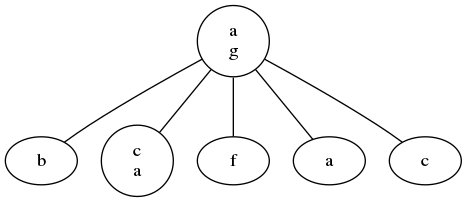

In [80]:
hlda=hierarchical_LDA(corpus2, alpha, beta, lambdas, eta, iters, level,num=5)
tree_plot(hlda,num=5)

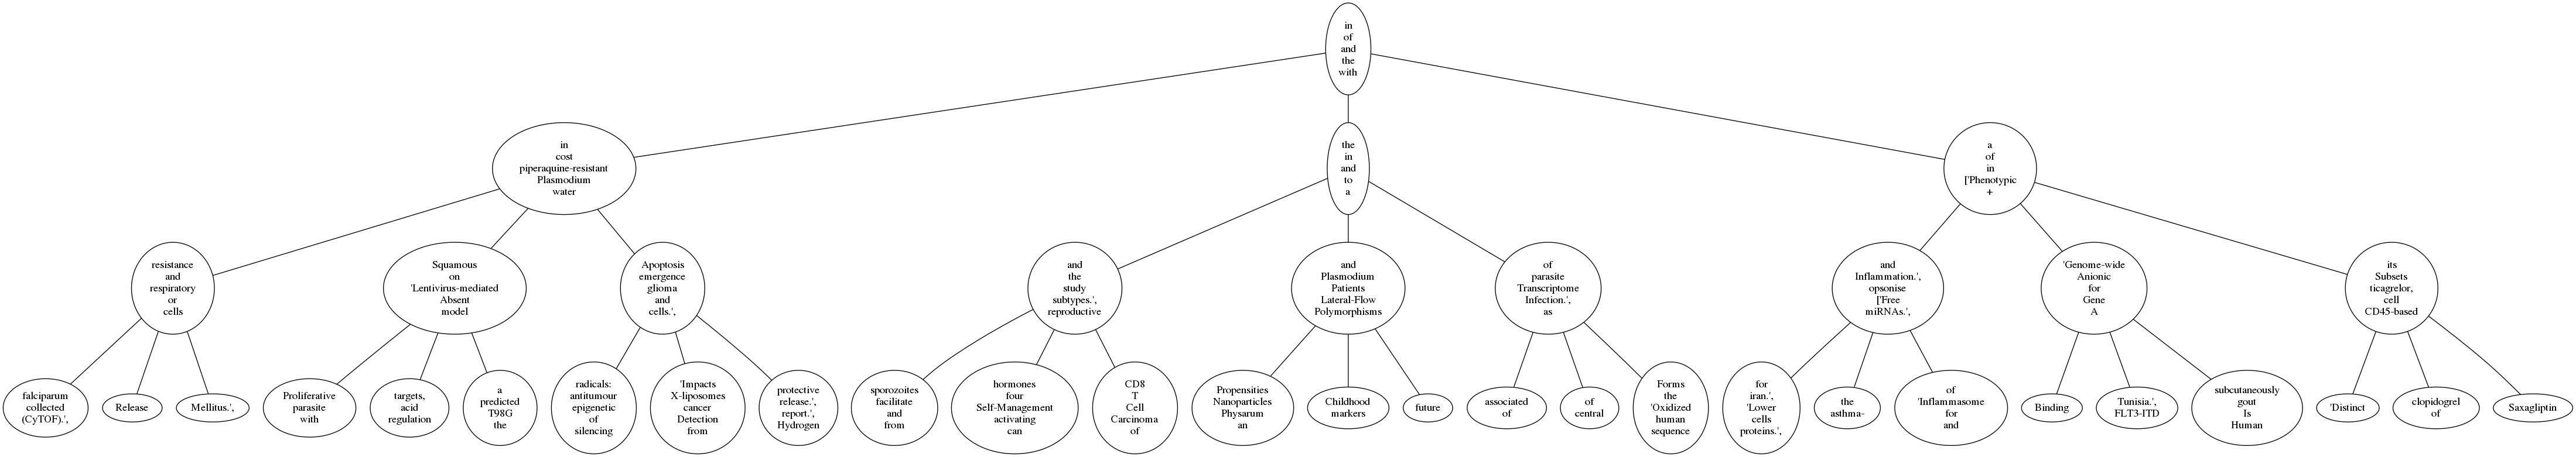

In [98]:
tree_plot(hlda2,num=5)